In [ ]:
# import pandas as pd
!pip install polars
!pip install gdown

^C
ERROR: Operation cancelled by user


In [1]:
import polars as pl

In [4]:
train = pl.read_parquet("train.parquet") 
test = pl.read_parquet("test.parquet")

In [5]:
camp_meta = pl.read_parquet("campaigns_meta.parquet") 
categories = pl.read_parquet("categories.parquet")

In [6]:
camp_meta.head(1)

adv_campaign_id,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id
i64,date,date,f64,f64,i64,i64
2153,2024-09-21,2024-10-02,6.661659,9429.056096,70,59


In [7]:
def drop_nan_rows(df):
    """
    Удаляет строки, содержащие NaN/null значения, из DataFrame.

    Parameters:
        df (pl.DataFrame): Входной DataFrame.

    Returns:
        pl.DataFrame: DataFrame без строк с NaN/null.
    """
    # Проверка на отсутствие null значений во всех столбцах
    return df.filter(
   pl.all_horizontal(pl.col(pl.Float32, pl.Float64).is_not_nan())
)

unique_logcat = categories.select([ 'vertical_id', 'category_id', 'logcat_id'])\
.unique().with_columns(pl.col('vertical_id').cast(pl.Int64),pl.col('category_id').cast(pl.Int64),
                       pl.col('logcat_id').cast(pl.Int64)).sort(["vertical_id","category_id","logcat_id"])\
.with_columns(pl.col(pl.Float32, pl.Float64).fill_nan(None)).drop_nulls()

In [8]:
unique_logcat = pl.from_pandas(unique_logcat.to_pandas().sort_values(by=['logcat_id'])\
.drop_duplicates(['logcat_id']))

In [9]:
camp_meta = camp_meta.join(unique_logcat, on="logcat_id", how="left")


In [10]:
camp_meta


adv_campaign_id,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id,vertical_id,category_id
i64,date,date,f64,f64,i64,i64,i64,i64
2153,2024-09-21,2024-10-02,6.661659,9429.056096,70,59,8,6
3103,2024-09-10,2024-09-16,2.853378,3844.482933,30,40,8,4
2816,2024-09-10,2024-09-17,3.05823,1455.156612,56,65,8,5
3603,2024-09-10,2024-09-16,4.395015,2592.232475,30,50,4,2
1328,2024-09-10,2024-09-16,3.891329,2836.139672,30,51,4,2
…,…,…,…,…,…,…,…,…
855,2024-09-18,2024-09-24,3.75875,525.462249,12,65,8,5
1781,2024-09-18,2024-09-24,4.122703,3814.655409,46,50,4,2
2485,2024-09-19,2024-09-29,4.00443,3485.343664,57,65,8,5


In [11]:

train

user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target
i64,i64,i64,i64,date,i64,bool,i32
2853707,3352,3,3075,2024-09-17,6,true,0
2537244,4029,2,3260,2024-09-17,8,true,0
63033,1578,3,1109,2024-09-17,6,true,0
164702,3434,1,1079,2024-09-17,7,true,0
2802905,2208,3,3576,2024-09-17,6,true,0
…,…,…,…,…,…,…,…
2670849,3904,2,3275,2024-09-08,8,true,0
3187004,2142,2,238,2024-09-08,8,true,0
821310,2414,2,2654,2024-09-08,8,true,0


In [12]:
train = train.with_columns(
    test = pl.lit(0)
)

test = test.with_columns(
    target = pl.lit(0)
)
test = test.with_columns(
    test = pl.lit(1)
)





In [13]:
train



user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target,test
i64,i64,i64,i64,date,i64,bool,i32,i32
2853707,3352,3,3075,2024-09-17,6,true,0,0
2537244,4029,2,3260,2024-09-17,8,true,0,0
63033,1578,3,1109,2024-09-17,6,true,0,0
164702,3434,1,1079,2024-09-17,7,true,0,0
2802905,2208,3,3576,2024-09-17,6,true,0,0
…,…,…,…,…,…,…,…,…
2670849,3904,2,3275,2024-09-08,8,true,0,0
3187004,2142,2,238,2024-09-08,8,true,0,0
821310,2414,2,2654,2024-09-08,8,true,0,0


In [14]:
test.head(1)

user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target,test
i64,i64,i64,i64,date,i64,bool,i32,i32
2714742,3026,2,4056,2024-09-23,8,true,0,1


In [15]:

train = train.extend(test)

In [16]:
train = train.join(camp_meta, how='left', on='adv_campaign_id')

NameError: name 'train' is not defined

Бейзлайн - если пользователь уже видел рекламу и кликнул на нее, то он снова сделает клик. Если же реклама была показана, но клик не последовал, то и в следующий раз клик маловероятен.

In [17]:
import polars as pl


def compute_remaining_budget(df):
    # Сортируем данные и вычисляем кумулятивную сумму затрат на клики с учетом предыдущих строк
    df = (
        df.sort(["adv_campaign_id", "event_date"])
        .with_columns(
            # Умножаем goal_cost на target и считаем кумулятивную сумму
            ((pl.col("goal_cost")/1000)   * (pl.col("target")) )
            .shift(1)
            .cum_sum()  # cumsum по каждой кампании
            #.shift(1)
            .fill_nan(0)
            .alias("cumulative_cost")
        )
        .with_columns(
            # Вычисляем оставшийся бюджет, вычитая накопленные расходы
            (pl.col("goal_budget") - pl.col("cumulative_cost")).alias("remaining_budget")
        )
    )
    return df



# Функция для вычисления кликов на объявление и кликов пользователем на объявление до текущего момента (исключая текущую строку)
def compute_click_counts_exclude_current(df):
    # Сначала сортируем данные по рекламной кампании и дате события
    df = df.sort(["adv_campaign_id", "event_date"])
    
    # Кумулятивное количество кликов на объявление (по каждому рекламному ID), исключая текущую строку
    df = df.with_columns(
        pl.when(pl.col("target") == 1)
        .then(1)
        .otherwise(0)
        .shift(1)
        .cum_sum()
        .over("adv_campaign_id")
        
        #.shift(1)
        .fill_nan(0)
        #.shift_and_fill(-1, 0)  # Смещаем на одну строку вверх
        .alias("ad_click_count")
    )
    
    # Кумулятивное количество кликов для пользователя на объявление (по каждому рекламному ID и пользователю), исключая текущую строку
    df = df.with_columns(
        pl.when(pl.col("target") == 1)
        .then(1)
        .otherwise(0)
        .shift(1)
        .cum_sum()
        .over(["adv_campaign_id", "user_id"])  
        #.shift(1)
        .fill_nan(0)  # Смещаем на одну строку вверх
        .alias("user_ad_click_count")
    )

    return df



updated_df = compute_remaining_budget(train)


updated_df = compute_click_counts_exclude_current(updated_df)


In [18]:

#changed t0 ads
# Функция для вычисления кликов на объявление и кликов пользователем на объявление(!!!!!) до текущего момента (исключая текущую строку)
def compute_click_counts_exclude_current_per_ads(df):
    # Сначала сортируем данные по рекламной кампании и дате события
    df = df.sort(["adv_creative_id", "event_date"])
    
    # Кумулятивное количество кликов на объявление (по каждому рекламному ID), исключая текущую строку
    df = df.with_columns(
        pl.when(pl.col("target") == 1)
        .then(1)
        .otherwise(0)
        
        .shift(1)
        .cum_sum()
        .over("adv_creative_id")
        #replace
        #.shift(1)
        .fill_nan(-1)
        #.shift_and_fill(-1, 0)  # Смещаем на одну строку вверх
        .alias("ad_click_count_per_ads")
    )
    
    # Кумулятивное количество кликов для пользователя на объявление (по каждому рекламному ID и пользователю), исключая текущую строку
    df = df.with_columns(
        pl.when(pl.col("target") == 1)
        .then(1)
        .otherwise(0)
        .shift(1)
        .cum_sum()
        .over(["adv_creative_id", "user_id"])  
        #.shift(1)
        .fill_nan(-1)  # Смещаем на одну строку вверх
        .alias("user_ad_click_count_per_ads")
    )

    return df

In [19]:
updated_df = compute_click_counts_exclude_current_per_ads(updated_df)

In [20]:
# Функция для вычисления количества просмотров и кликов за предыдущий день для каждой компании
def compute_prev_day_stats(df):

    # Считаем количество просмотров и кликов за каждый день по каждому объявлению
    daily_stats = df.group_by(["adv_campaign_id", "event_date"]).agg([
        pl.count().alias("daily_views_per_campaign"),
        pl.sum("target").alias("daily_clicks_per_campaign")  # Считаем только клики, где target = 1
    ])
    
    daily_stats = daily_stats.with_columns((pl.col("daily_views_per_campaign") - pl.col("daily_clicks_per_campaign")).alias('daily_views_per_campaign'))
    
    daily_stats = daily_stats.with_columns(( pl.col("daily_clicks_per_campaign")/pl.col("daily_views_per_campaign")).alias('ctr_daily_pred_per_campaign'))
    
    
    # Добавляем столбец "previous_day" для последующего объединения на день назад
    daily_stats = daily_stats.with_columns(
        (pl.col("event_date") + pl.duration(days=1)).alias("next_day")
    )
    
    # Присоединяем полученные результаты на день позже к оригинальному DataFrame
    df = df.join(
        daily_stats,
        left_on=["adv_campaign_id", "event_date"],
        right_on=["adv_campaign_id", "next_day"],
        how="left"
    )

    
    # Заменяем пустые значения на нули (если нет просмотров или кликов за предыдущий день)
    df = df.with_columns([
       pl.col("daily_views_per_campaign").fill_null(-1),
        pl.col("daily_clicks_per_campaign").fill_null(-1),
        pl.col("ctr_daily_pred_per_campaign").fill_null(-1),
        
        
        
    ])
    return df

In [21]:
updated_df = compute_prev_day_stats(updated_df)

/tmp/ipykernel_61921/3074706124.py:10: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("daily_views_per_campaign"),


In [22]:
updated_df = updated_df.drop("event_date_right")

In [23]:
updated_df.head()



user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target,test,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id,vertical_id,category_id,cumulative_cost,remaining_budget,ad_click_count,user_ad_click_count,ad_click_count_per_ads,user_ad_click_count_per_ads,daily_views_per_campaign,daily_clicks_per_campaign,ctr_daily_pred_per_campaign
i64,i64,i64,i64,date,i64,bool,i32,i32,date,date,f64,f64,i64,i64,i64,i64,f64,f64,i32,i32,i32,i32,i64,i32,f64
2234003,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,null,null,-1,-1,-1.0
1099576,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,0,null,-1,-1,-1.0
2923050,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,0,null,-1,-1,-1.0
2346641,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,0,null,-1,-1,-1.0
1979949,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,0,null,-1,-1,-1.0


In [24]:

# Функция для вычисления количества просмотров и кликов за предыдущий день для каждой компании
def compute_prev_day_stats_per_ads(df):

    # Считаем количество просмотров и кликов за каждый день по каждому объявлению
    daily_stats = df.group_by(["adv_creative_id", "event_date"]).agg([
        pl.count().alias("daily_views_per_ads"),
        pl.sum("target").alias("daily_clicks_per_ads")  # Считаем только клики, где target = 1
    ])
    
    
    daily_stats = daily_stats.with_columns((pl.col("daily_views_per_ads") - pl.col("daily_clicks_per_ads")).alias('daily_views_per_ads'))
    
    daily_stats = daily_stats.with_columns(( pl.col("daily_clicks_per_ads")/pl.col("daily_views_per_ads")).alias('ctr_daily_pred_per_ads'))

    
    
    # Добавляем столбец "previous_day" для последующего объединения на день назад
    daily_stats = daily_stats.with_columns(
        (pl.col("event_date") + pl.duration(days=1)).alias("next_day")
    )
    
    # Присоединяем полученные результаты на день позже к оригинальному DataFrame
    df = df.join(
        daily_stats,
        left_on=["adv_creative_id", "event_date"],
        right_on=["adv_creative_id", "next_day"],
        how="left"
    )
#     .select([
#         "adv_campaign_id", "event_date", "daily_views", "daily_clicks"
#     ])
    
    # Заменяем пустые значения на нули (если нет просмотров или кликов за предыдущий день)
    df = df.with_columns([
       pl.col("daily_clicks_per_ads").fill_null(-1),
        pl.col("daily_views_per_ads").fill_null(-1),
        pl.col("ctr_daily_pred_per_ads").fill_null(-1),
        
    ])
    return df

In [25]:
updated_df = compute_prev_day_stats_per_ads(updated_df)

/tmp/ipykernel_61921/3453609469.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("daily_views_per_ads"),


In [26]:
updated_df = updated_df.drop("event_date_right")

In [17]:
############new 
# Функция для вычисления количества просмотров и кликов за предыдущий день для каждой компании
def compute_user_id_common(df, col1='user_id', col2='logcat_id'):

    
    # Считаем количество просмотров и кликов за каждый день по каждому объявлению
    daily_stats = df.group_by([col1, col2, "event_date"]).agg([
        pl.count().alias(f"daily_views_per_{col1}_{col2}"),
        pl.sum("target").alias(f"daily_clicks_per_{col1}_{col2}")  # Считаем только клики, где target = 1
    ])
    
    
    
       
    daily_stats = daily_stats.with_columns((pl.col(f"daily_views_per_{col1}_{col2}") - pl.col(f"daily_clicks_per_{col1}_{col2}"))\
                                           .alias(f'daily_views_per_{col1}_{col2}'))
    
    daily_stats = daily_stats.with_columns(( pl.col(f"daily_clicks_per_{col1}_{col2}")/pl.col(f"daily_views_per_{col1}_{col2}"))\
                                           .alias(f'ctr_daily_pred_per_{col1}_{col2}'))

    
    
    
    # Добавляем столбец "previous_day" для последующего объединения на день назад
    daily_stats = daily_stats.with_columns(
        (pl.col("event_date") + pl.duration(days=1)).alias("next_day")
    )
    
    
    
    
    # Присоединяем полученные результаты на день позже к оригинальному DataFrame
    df = df.join(
        daily_stats,
        left_on=[col1, col2, "event_date"],
        right_on=[col1, col2, "next_day"],
        how="left"
    )

    df = df.with_columns([
       pl.col(f"daily_clicks_per_{col1}_{col2}").fill_null(-1),
        pl.col(f"daily_views_per_{col1}_{col2}").fill_null(-1),
        pl.col(f'ctr_daily_pred_per_{col1}_{col2}').fill_null(-1),
        
    ])

    
    df = df.drop("event_date_right")
    return df

In [29]:
updated_df


user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target,test,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id,vertical_id,category_id,cumulative_cost,remaining_budget,ad_click_count,user_ad_click_count,ad_click_count_per_ads,user_ad_click_count_per_ads,daily_views_per_campaign,daily_clicks_per_campaign,ctr_daily_pred_per_campaign,daily_views_per_ads,daily_clicks_per_ads,ctr_daily_pred_per_ads
i64,i64,i64,i64,date,i64,bool,i32,i32,date,date,f64,f64,i64,i64,i64,i64,f64,f64,i32,i32,i32,i32,i64,i32,f64,i64,i32,f64
2234003,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,null,null,-1,-1,-1.0,-1,-1,-1.0
1099576,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,0,null,-1,-1,-1.0,-1,-1,-1.0
2923050,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,0,null,-1,-1,-1.0,-1,-1,-1.0
2346641,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,0,null,-1,-1,-1.0,-1,-1,-1.0
1979949,1348,2,1,2024-09-01,8,true,0,0,2024-08-28,2024-09-20,3.556529,715.279026,78,56,8,11,1087.547997,-372.268971,0,null,0,null,-1,-1,-1.0,-1,-1,-1.0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
1500413,1025,2,4302,2024-09-23,5,false,0,1,2024-09-16,2024-10-15,4.690097,38809.863468,1,65,8,5,825.33893,37984.524538,407,null,407,null,11616,47,0.004046,11616,47,0.004046
1721348,1025,2,4302,2024-09-23,5,false,0,1,2024-09-16,2024-10-15,4.690097,38809.863468,1,65,8,5,825.33893,37984.524538,407,null,407,null,11616,47,0.004046,11616,47,0.004046
93957,1025,2,4302,2024-09-23,8,true,0,1,2024-09-16,2024-10-15,4.690097,38809.863468,1,65,8,5,825.33893,37984.524538,407,0,407,0,11616,47,0.004046,11616,47,0.004046


In [30]:
#changed t0 ads and location
# Функция для вычисления количества просмотров и кликов за предыдущий день для каждой компании
def compute_prev_day_stats_per_ads_per_location(df):

    
    # Считаем количество просмотров и кликов за каждый день по каждому объявлению
    daily_stats = df.group_by(["adv_creative_id", 'location_id', "event_date"]).agg([
        pl.count().alias("daily_views_per_ads_loc"),
        pl.sum("target").alias("daily_clicks_per_ads_loc")  # Считаем только клики, где target = 1
    ])
    
    # Добавляем столбец "previous_day" для последующего объединения на день назад
    daily_stats = daily_stats.with_columns(
        (pl.col("event_date") + pl.duration(days=1)).alias("next_day")
    )
    
    # Присоединяем полученные результаты на день позже к оригинальному DataFrame
    df = df.join(
        daily_stats,
        left_on=["adv_creative_id", 'location_id', "event_date"],
        right_on=["adv_creative_id", 'location_id', "next_day"],
        how="left"
    )

    # Заменяем пустые значения на нули (если нет просмотров или кликов за предыдущий день)
    df = df.with_columns([
       pl.col("daily_views_per_ads_loc").fill_null(-1),
        pl.col("daily_clicks_per_ads_loc").fill_null(-1),
        
    ])
    return df

In [31]:
updated_df = compute_prev_day_stats_per_ads_per_location(updated_df)

/tmp/ipykernel_61921/3515010437.py:11: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias("daily_views_per_ads_loc"),


In [4]:
import numpy as np

def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df




In [6]:
# usage example
updated_df = reduce_memory_usage_pl(updated_df, "train_subset")

Memory usage of dataframe train_subset is 55964.68 MB
Memory usage of dataframe train_subset became 55964.68 MB


In [7]:
# Функция для вычисления кумулятивного количества просмотров и кликов по user_id и logcat_id до текущего наблюдения
def compute_user_logcat_stats(df):
    # Сортировка по user_id, logcat_id и event_date для корректного накопления
    df = df.sort(["user_id", "logcat_id", "event_date"])

    return df



In [38]:
#updated_df = compute_user_logcat_stats(updated_df)

In [39]:


def compute_user_adv_views(df):
    # Убедимся, что даты в формате Date для корректной сортировки
    #df = df.with_columns(pl.col("event_date").str.strptime(pl.Date, "%Y-%m-%d"))

    # Сортировка по user_id, adv_campaign_id и event_date
    df = df.sort(["user_id", "adv_campaign_id", "event_date"])

    # Вычисляем кумулятивное количество просмотров по каждому объявлению, не исключая текущее наблюдение
    df = df.with_columns([
        #fixed shift
        # Кумулятивная сумма просмотров, исключая текущее наблюдение
        pl.col("target").shift(1).cum_count().over(["user_id", "adv_campaign_id"])
        .fill_nan(-1).alias("cumulative_adv_peruser_views")
    ])
    
    
    df = df.with_columns([
        # Кумулятивная сумма просмотров, исключая текущее наблюдение
        
        #fixed shift
        pl.col("target").shift(1).cum_count().over(["adv_campaign_id"])
        .fill_nan(-1).alias("cumulative_adv_all_views")
    ])
    
    return df

In [40]:
del train

del test

In [41]:
import gc
gc.collect()

0

In [42]:
updated_df = reduce_memory_usage_pl(updated_df, "train_subset")


Memory usage of dataframe train_subset is 9935.04 MB
Memory usage of dataframe train_subset became 9935.04 MB


In [43]:
categories = reduce_memory_usage_pl(categories, "cat_subset")

Memory usage of dataframe cat_subset is 1.2 MB
Memory usage of dataframe cat_subset became 0.61 MB


In [44]:

updated_df = compute_user_adv_views(updated_df)

In [45]:


def compute_user_adv_views_per_ads(df):
    # Убедимся, что даты в формате Date для корректной сортировки
    #df = df.with_columns(pl.col("event_date").str.strptime(pl.Date, "%Y-%m-%d"))

    # Сортировка по user_id, adv_campaign_id и event_date
    df = df.sort(["user_id", "adv_creative_id", "event_date"])

    # Вычисляем кумулятивное количество просмотров по каждому объявлению, не исключая текущее наблюдение
    df = df.with_columns([
        # Кумулятивная сумма просмотров, исключая текущее наблюдение
        pl.col("target").shift(1).cum_count().over(["user_id", "adv_creative_id"])
        .fill_nan(-1).alias("cumulative_adv_peruser_views_ads")
    ])
    
    
    df = df.with_columns([
        # Кумулятивная сумма просмотров, исключая текущее наблюдение
        pl.col("target").shift(1).cum_count().over(["adv_creative_id"])
        .fill_nan(-1).alias("cumulative_adv_all_views_ads")
    ])
    
    return df

In [46]:
updated_df = compute_user_adv_views_per_ads(updated_df)

In [47]:

categories = categories.with_columns(pl.col("logcat_id").cast(pl.Int8))



In [48]:
def count_microcats_per_logcat(df, cats):
    result = (
        cats
        .group_by("logcat_id")
        .agg(
            pl.col("microcat_id").n_unique().alias("unique_microcat_count")
        )
    )
    
    return df.join(result, on="logcat_id", how="left")
    #return result

In [49]:
updated_df = reduce_memory_usage_pl(updated_df, "train_subset")
categories = reduce_memory_usage_pl(categories, "cat_subset")

Memory usage of dataframe train_subset is 13469.36 MB
Memory usage of dataframe train_subset became 11020.38 MB
Memory usage of dataframe cat_subset is 0.53 MB
Memory usage of dataframe cat_subset became 0.53 MB


In [50]:
updated_df = count_microcats_per_logcat(updated_df, categories)

In [51]:
def count_creatives_per_campaign(df):
    # Считаем уникальные объявления (adv_creative_id) для каждой кампании (adv_campaign_id)
    campaign_stats = (
        df.group_by("adv_campaign_id")
        .agg(pl.col("adv_creative_id").n_unique().alias("unique_creatives_per_campaign"))
    )
    
    # Считаем, в скольких кампаниях участвует каждое объявление
    creative_stats = (
        df.group_by("adv_creative_id")
        .agg(pl.col("adv_campaign_id").n_unique().alias("campaign_count_per_creative"))
    )
    
    # Объединяем результаты в один DataFrame
    result_df = df.join(campaign_stats, on="adv_campaign_id", how="left") \
                  .join(creative_stats, on="adv_creative_id", how="left")
    
    return result_df

In [52]:
updated_df = count_creatives_per_campaign(updated_df)

In [53]:
from tqdm import tqdm

In [2]:


def compute_user_banner_stats_expanded(df):
    # Сортировка по user_id, banner_code, и event_date, чтобы учитывать порядок событий для каждого баннера
    df = df.sort(["user_id", "banner_code", "event_date"])
    
    # Получаем уникальные значения banner_code
    unique_banners = df.select("banner_code").unique().to_series()
    
    # Создаем пустой DataFrame для хранения результатов
    results = df
    
    # Для каждого уникального banner_code создаем отдельные кумулятивные столбцы для просмотров и кликов
    for banner in unique_banners:
        view_col = f"views_banner_{banner}"
        click_col = f"clicks_banner_{banner}"
        
        # Добавляем кумулятивные просмотры и клики для текущего banner_code, исключая текущее наблюдение
        results = results.with_columns([
            # Кумулятивные просмотры для каждого баннера (target=0), исключая текущее наблюдение
            pl.when(pl.col("banner_code") == banner)
              .then((pl.col("target") == 0).shift(1).cum_sum().over(["user_id", "banner_code"]))
              .otherwise(None)
              .alias(view_col),
            
            # Кумулятивные клики для каждого баннера (target=1), исключая текущее наблюдение
            pl.when(pl.col("banner_code") == banner)
              .then((pl.col("target") == 1).shift(1).cum_sum().over(["user_id", "banner_code"]))
              .otherwise(None)
              .alias(click_col)
        ])
    for banner in unique_banners:  
        results = results.with_columns(
            pl.col(f"clicks_banner_{banner}").fill_null(strategy="forward").over("user_id")
    )
        results = results.with_columns(
            pl.col(f"views_banner_{banner}").fill_null(strategy="forward").over("user_id")
    )
    
    
        results = results.with_columns(
                pl.col(f"clicks_banner_{banner}").fill_null(0)
        )
        results = results.with_columns(
                pl.col(f"views_banner_{banner}").fill_null(0)
        )


    
    # Заполняем NaN значения нулями
    #results = results.fill_null(No)
    
    return results


def compute_user_platform_id_stats_expanded(df):
    # Сортировка по user_id, banner_code, и event_date, чтобы учитывать порядок событий для каждого баннера
    df = df.sort(["user_id", "platform_id", "event_date"])
    
    # Получаем уникальные значения banner_code
    unique_banners = df.select("platform_id").unique().to_series()
    
    # Создаем пустой DataFrame для хранения результатов
    results = df
    
    # Для каждого уникального banner_code создаем отдельные кумулятивные столбцы для просмотров и кликов
    for banner in unique_banners:
        view_col = f"views_platform_id_{banner}"
        click_col = f"clicks_platform_id_{banner}"
        
        # Добавляем кумулятивные просмотры и клики для текущего banner_code, исключая текущее наблюдение
        results = results.with_columns([
            # Кумулятивные просмотры для каждого баннера (target=0), исключая текущее наблюдение
            pl.when(pl.col("platform_id") == banner)
              .then((pl.col("target") == 0).shift(1).cum_sum().over(["user_id", "platform_id"]))
              .otherwise(None)
              .alias(view_col),
            
            # Кумулятивные клики для каждого баннера (target=1), исключая текущее наблюдение
            pl.when(pl.col("platform_id") == banner)
              .then((pl.col("target") == 1).shift(1).cum_sum().over(["user_id", "platform_id"]))
              .otherwise(None)
              .alias(click_col)
        ])
    for banner in unique_banners:  
        results = results.with_columns(
            pl.col(f"clicks_platform_id_{banner}").fill_null(strategy="forward").over("user_id")
    )
        results = results.with_columns(
            pl.col(f"views_platform_id_{banner}").fill_null(strategy="forward").over("user_id")
    )
    
    
        results = results.with_columns(
                pl.col(f"clicks_platform_id_{banner}").fill_null(0)
        )
        results = results.with_columns(
                pl.col(f"views_platform_id_{banner}").fill_null(0)
        )



    return results



def compute_user_logcat_id_stats_expanded(df):
    # Сортировка по user_id, banner_code, и event_date, чтобы учитывать порядок событий для каждого баннера
    df = df.sort(["user_id", "logcat_id", "event_date"])
    
    # Получаем уникальные значения banner_code
    unique_banners = df.select("logcat_id").unique().to_series()
    
    # Создаем пустой DataFrame для хранения результатов
    results = df
    
    # Для каждого уникального banner_code создаем отдельные кумулятивные столбцы для просмотров и кликов
    for banner in tqdm(unique_banners):
        view_col = f"views_logcat_id_{banner}"
        click_col = f"clicks_logcat_id_{banner}"
        
        # Добавляем кумулятивные просмотры и клики для текущего banner_code, исключая текущее наблюдение
        results = results.with_columns([
            #Кумулятивные просмотры для каждого баннера (target=0), исключая текущее наблюдение
            pl.when(pl.col("logcat_id") == banner)
              .then((pl.col("target") == 0).shift(1).cum_sum().over(["user_id", "logcat_id"]))
              .otherwise(None)
              .alias(view_col),
            
            # Кумулятивные клики для каждого баннера (target=1), исключая текущее наблюдение
            pl.when(pl.col("logcat_id") == banner)
              .then((pl.col("target") == 1).shift(1).cum_sum().over(["user_id", "logcat_id"]))
              .otherwise(None)
              .alias(click_col)
        ])
    for banner in unique_banners:  
        results = results.with_columns(
            pl.col(f"clicks_logcat_id_{banner}").fill_null(strategy="forward").over("user_id")
    )
        results = results.with_columns(
            pl.col(f"views_logcat_id_{banner}").fill_null(strategy="forward").over("user_id")
    )
    
    
        results = results.with_columns(
                pl.col(f"clicks_logcat_id_{banner}").fill_null(0)
        )
        results = results.with_columns(
                pl.col(f"views_logcat_id_{banner}").fill_null(0)
        )


    
    # Заполняем NaN значеcния нулями
    #results = results.fill_null(No)
    
    return results







In [15]:
updated_df = compute_user_banner_stats_expanded(updated_df)

KeyboardInterrupt: 

In [56]:
updated_df = compute_user_platform_id_stats_expanded(updated_df)

In [57]:
updated_df = reduce_memory_usage_pl(updated_df, "train_subset")

Memory usage of dataframe train_subset is 23153.93 MB
Memory usage of dataframe train_subset became 23153.93 MB


In [58]:
updated_df.write_parquet("data.parquet")

In [ ]:
updated_df = compute_user_logcat_id_stats_expanded(updated_df)

  8%|▊         | 3/37 [03:45<42:31, 75.05s/it]

In [102]:
updated_df.write_parquet("data.parquet")

NameError: name 'updated_df' is not defined

In [ ]:
updated_df = reduce_memory_usage_pl(updated_df, "train_subset")

In [104]:



import polars as pl
import numpy as np
updated_df = pl.read_parquet("data.parquet") 

In [106]:
updated_df.head()

def add_unique_id(df: pl.DataFrame, id_column: str = "unique_id") -> pl.DataFrame:
    """
    Добавляет уникальный идентификатор для каждой строки в DataFrame.

    Args:
        df (pl.DataFrame): Исходный DataFrame.
        id_column (str): Имя столбца с уникальными идентификаторами. По умолчанию 'unique_id'.

    Returns:
        pl.DataFrame: Новый DataFrame с добавленным уникальным идентификатором.
    """
    return df.with_row_count(id_column)

updated_df = add_unique_id(updated_df)



/tmp/ipykernel_158624/1591028037.py:14: DeprecationWarning: `DataFrame.with_row_count` is deprecated. Use `with_row_index` instead. Note that the default column name has changed from 'row_nr' to 'index'.
  return df.with_row_count(id_column)


In [107]:
updated_df.write_parquet("data_1.parquet")

In [108]:
#################################################################################################


updated_df = updated_df.select(['unique_id', 'user_id',	'adv_campaign_id',	'platform_id',	
                   'adv_creative_id',	'event_date',	'category_id', 'logcat_id',
                   
                   'banner_code',	'is_main',	'target',	'test',	'start_date',	'end_date', 'vertical_id'])

In [109]:
from tqdm import tqdm

import numpy as np

def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df




In [110]:



def compute_user_vertical_id_stats_expanded(df):
    # Сортировка по user_id, banner_code, и event_date, чтобы учитывать порядок событий для каждого баннера
    df = df.sort(["user_id", "vertical_id", "event_date"])
    
    # Получаем уникальные значения banner_code
    unique_banners = df.select("vertical_id").unique().to_series()
    
    # Создаем пустой DataFrame для хранения результатов
    results = df
    
    # Для каждого уникального banner_code создаем отдельные кумулятивные столбцы для просмотров и кликов
    for banner in unique_banners:
        view_col = f"views_vertical_id_{banner}"
        click_col = f"clicks_vertical_id_{banner}"
        
        # Добавляем кумулятивные просмотры и клики для текущего banner_code, исключая текущее наблюдение
        results = results.with_columns([
            # Кумулятивные просмотры для каждого баннера (target=0), исключая текущее наблюдение
            pl.when(pl.col("vertical_id") == banner)
              .then((pl.col("target") == 0).shift(1).cum_sum().over(["user_id", "vertical_id"]))
              .otherwise(None)
              .alias(view_col),
            
            # Кумулятивные клики для каждого баннера (target=1), исключая текущее наблюдение
            pl.when(pl.col("vertical_id") == banner)
              .then((pl.col("target") == 1).shift(1).cum_sum().over(["user_id", "vertical_id"]))
              .otherwise(None)
              .alias(click_col)
        ])
    for banner in tqdm(unique_banners):  
        results = results.with_columns(
            pl.col(f"clicks_vertical_id_{banner}").fill_null(strategy="forward").over("user_id")
    )
        results = results.with_columns(
            pl.col(f"views_vertical_id_{banner}").fill_null(strategy="forward").over("user_id")
    )
    
    
        results = results.with_columns(
                pl.col(f"clicks_vertical_id_{banner}").fill_null(0)
        )
        results = results.with_columns(
                pl.col(f"views_vertical_id_{banner}").fill_null(0)
        )


    
    # Заполняем NaN значения нулями
    #results = results.fill_null(No)
    
    return results


In [111]:


updated_df = compute_user_vertical_id_stats_expanded(updated_df)

100%|██████████| 5/5 [00:26<00:00,  5.37s/it]


In [112]:
updated_df = reduce_memory_usage_pl(updated_df, "train_subset")

Memory usage of dataframe train_subset is 8056.57 MB
Memory usage of dataframe train_subset became 8056.57 MB


In [114]:



def compute_user_category_id_stats_expanded(df):
    # Сортировка по user_id, banner_code, и event_date, чтобы учитывать порядок событий для каждого баннера
    df = df.sort(["user_id", "category_id", "event_date"])
    
    # Получаем уникальные значения banner_code
    unique_banners = df.select("category_id").unique().to_series()
    
    # Создаем пустой DataFrame для хранения результатов
    results = df
    
    # Для каждого уникального banner_code создаем отдельные кумулятивные столбцы для просмотров и кликов
    for banner in unique_banners:
        view_col = f"views_category_id_{banner}"
        click_col = f"clicks_category_id_{banner}"
        
        # Добавляем кумулятивные просмотры и клики для текущего banner_code, исключая текущее наблюдение
        results = results.with_columns([
            # Кумулятивные просмотры для каждого баннера (target=0), исключая текущее наблюдение
            pl.when(pl.col("category_id") == banner)
              .then((pl.col("target") == 0).shift(1).cum_sum().over(["user_id", "category_id"]))
              .otherwise(None)
              .alias(view_col),
            
            # Кумулятивные клики для каждого баннера (target=1), исключая текущее наблюдение
            pl.when(pl.col("category_id") == banner)
              .then((pl.col("target") == 1).shift(1).cum_sum().over(["user_id", "category_id"]))
              .otherwise(None)
              .alias(click_col)
        ])
    for banner in tqdm(unique_banners):  
        results = results.with_columns(
            pl.col(f"clicks_category_id_{banner}").fill_null(strategy="forward").over("user_id")
    )
        results = results.with_columns(
            pl.col(f"views_category_id_{banner}").fill_null(strategy="forward").over("user_id")
    )
    
    
        results = results.with_columns(
                pl.col(f"clicks_category_id_{banner}").fill_null(0)
        )
        results = results.with_columns(
                pl.col(f"views_category_id_{banner}").fill_null(0)
        )


    
    # Заполняем NaN значения нулями
    #results = results.fill_null(No)
    
    return results
# vertical_id	

In [115]:



updated_df = compute_user_category_id_stats_expanded(updated_df)

100%|██████████| 10/10 [00:51<00:00,  5.20s/it]


In [116]:
updated_df = reduce_memory_usage_pl(updated_df, "train_subset")

Memory usage of dataframe train_subset is 17101.07 MB
Memory usage of dataframe train_subset became 17101.07 MB


In [117]:
import polars as pl

def calculate_stats(df):
    # Сортируем данные по пользователю, объявлению и дате
    df = df.sort(["user_id", "adv_creative_id", "event_date"])

    # Группируем по пользователю и объявлению
    df = df.with_columns(
        [

            pl.col("event_date").shift(1).over(["user_id", "adv_creative_id"]).alias("prev_event_date"),
            pl.col("target").shift(1).cum_sum().over(["user_id", "adv_creative_id"]).alias("clicks_so_far").fill_null(-1),
            (pl.col("target").eq(0).shift(1).cum_sum().over(["user_id", "adv_creative_id"])).alias("views_so_far").fill_null(-1),
            
            
        ]
    )

    # Вычисляем количество дней с момента последнего клика
    df = df.with_columns(
        [
            pl.when(pl.col("prev_event_date").is_not_null())
            .then(((pl.col("event_date") - pl.col("prev_event_date")).dt.total_days()) )
            .otherwise(None)
            .alias("days_since_last_click"),
        ]
    )
    
    
    
    df = df.with_columns(
        pl.when(pl.col("target") <2)
        .then(pl.col("days_since_last_click"))
        .otherwise(None)
        .fill_null(-1)
        .cast(pl.Int32)
        .alias("days_since_last_view")
    )
        

    df = df.drop(['days_since_last_click', 'prev_event_date'])
    

    


    return df

In [120]:
updated_df

unique_id,user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,category_id,logcat_id,banner_code,is_main,target,test,start_date,end_date,vertical_id,views_vertical_id_9,clicks_vertical_id_9,views_vertical_id_3,clicks_vertical_id_3,views_vertical_id_4,clicks_vertical_id_4,views_vertical_id_5,clicks_vertical_id_5,views_vertical_id_8,clicks_vertical_id_8,views_category_id_6,clicks_category_id_6,views_category_id_3,clicks_category_id_3,views_category_id_9,clicks_category_id_9,views_category_id_7,clicks_category_id_7,views_category_id_1,clicks_category_id_1,views_category_id_4,clicks_category_id_4,views_category_id_2,clicks_category_id_2,views_category_id_5,clicks_category_id_5,views_category_id_11,clicks_category_id_11,views_category_id_8,clicks_category_id_8
u32,i32,i16,i8,i16,date,i8,i8,i8,bool,i8,i8,date,date,i8,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32,u32
219,1,2652,1,3301,2024-09-01,1,35,7,true,0,0,2024-08-23,2024-09-05,9,0,0,0,0,82,0,186,0,89,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
220,1,2652,1,3301,2024-09-05,1,35,7,true,0,0,2024-08-23,2024-09-05,9,1,0,0,0,82,0,186,0,89,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0
221,1,1063,1,1294,2024-09-09,1,35,7,true,0,0,2024-09-09,2024-09-15,9,2,0,0,0,82,0,186,0,89,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
223,1,563,1,2547,2024-09-10,1,35,7,true,0,0,2024-09-10,2024-09-16,9,4,0,0,0,82,0,186,0,89,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
222,1,1063,1,1294,2024-09-10,1,35,7,true,0,0,2024-09-09,2024-09-15,9,3,0,0,0,82,0,186,0,89,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
116724317,3263622,289,2,2633,2024-09-12,1,35,8,true,0,0,2024-09-10,2024-09-16,9,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,2,0,0,0,0,0,0,0,0,0,0,0
116724318,3263622,1993,2,3250,2024-09-12,1,35,8,true,0,0,2024-09-10,2024-09-16,9,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,0,0,0,0,0,0,0,0,0,0,0
116724319,3263622,1178,2,680,2024-09-13,1,35,5,false,0,0,2024-09-11,2024-09-17,9,4,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,4,0,0,0,0,0,0,0,0,0,0,0


In [121]:
updated_df.drop(['platform_id',	'user_id', 	'adv_campaign_id',	'platform_id',	
                   'adv_creative_id',
                  'event_date',	'category_id', 'logcat_id',
                   
                   'banner_code',	'is_main',	'target',	'test',	'start_date',	'end_date', 'vertical_id']).write_parquet("data_2.parquet")

In [122]:
import gc
gc.collect()

45593

In [1]:
import polars as pl
import numpy as np

In [2]:
def reduce_memory_usage_pl(df, name):
    """ Reduce memory usage by polars dataframe {df} with name {name} by changing its data types.
        Original pandas version of this function: https://www.kaggle.com/code/arjanso/reducing-dataframe-memory-size-by-65 """
    print(f"Memory usage of dataframe {name} is {round(df.estimated_size('mb'), 2)} MB")
    Numeric_Int_types = [pl.Int8,pl.Int16,pl.Int32,pl.Int64]
    Numeric_Float_types = [pl.Float32,pl.Float64]    
    for col in df.columns:
        col_type = df[col].dtype
        c_min = df[col].min()
        c_max = df[col].max()
        if col_type in Numeric_Int_types:
            if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                df = df.with_columns(df[col].cast(pl.Int8))
            elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                df = df.with_columns(df[col].cast(pl.Int16))
            elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                df = df.with_columns(df[col].cast(pl.Int32))
            elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                df = df.with_columns(df[col].cast(pl.Int64))
        elif col_type in Numeric_Float_types:
            if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                df = df.with_columns(df[col].cast(pl.Float32))
            else:
                pass
        elif col_type == pl.Utf8:
            df = df.with_columns(df[col].cast(pl.Categorical))
        else:
            pass
    print(f"Memory usage of dataframe {name} became {round(df.estimated_size('mb'), 2)} MB")
    return df



In [3]:
updated_df = pl.scan_parquet("data_1.parquet").join(pl.scan_parquet("data_2.parquet"), how='left', on=['unique_id'])

In [6]:
#updated_df
import gc
gc.collect()

0

In [7]:
# updated_df[updated_df.select(pl.col('target') == 1)]

updated_df.filter(pl.col("test") == 1)

In [8]:
import numpy as np

In [9]:
import datetime

In [12]:
test_data = updated_df.filter(pl.col("test") == 1).drop(["test"]).collect()

In [15]:
non_null_df = updated_df.filter(( pl.col("target") == 1)).drop(["test"]).collect()

In [16]:
test_data.write_parquet("test_batch.parquet")
non_null_df.write_parquet("positive_batch.parquet")

In [17]:
del test_data, non_null_df

In [18]:
del updated_df

In [19]:
import polars as pl

In [20]:
null_df = pl.read_parquet("data_1.parquet")\
.sample(fraction=0.11, with_replacement=False, shuffle=True)


#pl.read_parquet("data.parquet").sample(fraction=0.07, with_replacement=False, shuffle=True)

In [21]:
#fix
null_df = null_df.join(pl.read_parquet("data_2.parquet"), how='left', on=['unique_id'])

In [22]:
null_df = null_df.filter(( pl.col("target") == 0) & ( pl.col("test") == 0))

In [23]:
train_data = pl.concat([null_df.drop(["test"]), pl.read_parquet("positive_batch.parquet")])

In [24]:
test_data = pl.read_parquet("test_batch.parquet")

In [25]:
train_data.shape

(13170030, 167)

In [26]:
test_data.shape

(1983287, 167)

In [27]:
train_data.select('target').mean()

target
f64
0.046782


In [28]:
def stratified_sampling(df, ratio0, ratio1):
    # Разделяем датафрейм по классам
#     df_class_0 = df.filter(pl.col("target") == 0)
#     df_class_1 = df.filter(pl.col("target") == 1)
    
    # Вычисляем количество примеров, которое нужно выбрать для каждого класса
    sample_size_0 = int(len(df.filter(pl.col("target") == 0)) * ratio0 / 100)
    sample_size_1 = int(len(df.filter(pl.col("target") == 1)) * ratio1 / 100)
    

    # Объединяем результаты и возвращаем финальный датафрейм
    sampled_df = pl.concat([ df.filter(pl.col("target") == 0).sample(n=sample_size_0, with_replacement=False), 
                            df.filter(pl.col("target") == 1).sample(n=sample_size_1, with_replacement=False)])
    
    return sampled_df

In [31]:
log_cats = sorted([i.split("_")[-1] for i in train_data.columns  if "views_logcat" in i ])
    

In [32]:
def compute_days_difference(df):
    # Убедимся, что start_date и event_date в формате даты
#     df = df.with_columns([
#         #pl.col("start_date").str.strptime(pl.Date, "%Y-%m-%d"),
#         pl.col("end_date").str.strptime(pl.Date, "%Y-%m-%d")
#     ])
    
    # Вычисляем разницу в днях
    df = df.with_columns(
        (pl.col("event_date") - pl.col("start_date")).dt.total_days().alias("days_difference_passed")
       
    )
    
    df = df.with_columns(
       (pl.col("end_date") - pl.col("event_date")).dt.total_days().alias("days_difference_remained")
       
    )
    
    df = df.with_columns(
        (pl.col("end_date") - pl.col("start_date")).dt.total_days().alias("days_difference_total")
       
    )
    
     
       
    
    
    
    return df

In [33]:
train_data = compute_days_difference(train_data)

test_data  =  compute_days_difference(test_data)

In [34]:
train_data = train_data.with_columns((pl.col("daily_clicks_per_ads_loc")/pl.col("daily_views_per_ads_loc"))   .alias("ctr_per_ads_loc"))

train_data = train_data.with_columns((pl.col("remaining_budget")/pl.col("goal_budget"))   .alias("left_budget_ratio"))



test_data = test_data.with_columns((pl.col("daily_clicks_per_ads_loc")/pl.col("daily_views_per_ads_loc"))   .alias("ctr_per_ads_loc"))

test_data = test_data.with_columns((pl.col("remaining_budget")/pl.col("goal_budget"))   .alias("left_budget_ratio"))

In [35]:
from tqdm import tqdm

In [37]:

# дописать 

def compute_ctr_logcats(df):
    # Вычисляем CTR с учетом деления на ноль
    for i in tqdm(log_cats):
        df = df.with_columns(
            (
                pl.when(pl.col(f"views_logcat_id_{i}") > 0)
                .then(pl.col(f"clicks_logcat_id_{i}") / pl.col(f"views_logcat_id_{i}"))
                .otherwise(0)
                .alias(f"ctr_logcat_id_{i}")
            )
        )
    return df


In [39]:

# дописать 

def compute_ctr(df):
    # Вычисляем CTR с учетом деления на ноль
    for i in tqdm(range(1, 9)):
        df = df.with_columns(
            (
                pl.when(pl.col(f"views_banner_{i}") > 0)
                .then(pl.col(f"clicks_banner_{i}") / pl.col(f"views_banner_{i}"))
                .otherwise(0)
                .alias(f"ctr_banner_{i}")
            )
        )
    return df



In [40]:
test_data = compute_ctr(test_data)

train_data = compute_ctr(train_data)


100%|██████████| 8/8 [00:00<00:00, 69.43it/s]


In [42]:
#train_data.select("platform_id").unique()

# дописать 



def compute_ctr_vertical(df):
    # Вычисляем CTR с учетом деления на ноль
    for i in tqdm([3,4,5,8,9]):
        df = df.with_columns(
            (
                pl.when(pl.col(f"views_vertical_id_{i}") > 0)
                .then(pl.col(f"clicks_vertical_id_{i}") / pl.col(f"views_vertical_id_{i}"))
                .otherwise(0)
                .alias(f"ctr_vertical_id_{i}")
            )
        )
    return df


In [43]:
test_data = compute_ctr_vertical(test_data)

train_data = compute_ctr_vertical(train_data)


100%|██████████| 5/5 [00:00<00:00, 78.37it/s]


In [44]:

def compute_ctr_category(df):
    # Вычисляем CTR с учетом деления на ноль
    for i in tqdm([1,2,3,4,5,6,7,8,9,11]):
        df = df.with_columns(
            (
                pl.when(pl.col(f"views_category_id_{i}") > 0)
                .then(pl.col(f"clicks_category_id_{i}") / pl.col(f"views_category_id_{i}"))
                .otherwise(0)
                .alias(f"ctr_category_id_{i}")
            )
        )
    return df


In [45]:
test_data = compute_ctr_category(test_data)

train_data = compute_ctr_category(train_data)


100%|██████████| 10/10 [00:00<00:00, 85.34it/s]


In [46]:

def compute_ctr_views(df):
    # Вычисляем CTR с учетом деления на ноль
    for i in tqdm(range(1, 5)):
        df = df.with_columns(
            (
                pl.when(pl.col(f"views_platform_id_{i}") > 0)
                .then(pl.col(f"clicks_platform_id_{i}") / pl.col(f"views_platform_id_{i}"))
                .otherwise(0)
                .alias(f"ctr_platform_id_{i}")
            )
        )
    return df


In [50]:
train_data.head()

unique_id,user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target,start_date,end_date,goal_cost,goal_budget,location_id,logcat_id,vertical_id,category_id,cumulative_cost,remaining_budget,ad_click_count,user_ad_click_count,ad_click_count_per_ads,user_ad_click_count_per_ads,daily_views_per_campaign,daily_clicks_per_campaign,ctr_daily_pred_per_campaign,daily_views_per_ads,daily_clicks_per_ads,ctr_daily_pred_per_ads,event_date_right,daily_views_per_ads_loc,daily_clicks_per_ads_loc,cumulative_adv_peruser_views,cumulative_adv_all_views,cumulative_adv_peruser_views_ads,cumulative_adv_all_views_ads,unique_microcat_count,…,clicks_category_id_4,views_category_id_2,clicks_category_id_2,views_category_id_5,clicks_category_id_5,views_category_id_11,clicks_category_id_11,views_category_id_8,clicks_category_id_8,days_difference_passed,days_difference_remained,days_difference_total,ctr_per_ads_loc,left_budget_ratio,ctr_banner_1,ctr_banner_2,ctr_banner_3,ctr_banner_4,ctr_banner_5,ctr_banner_6,ctr_banner_7,ctr_banner_8,ctr_vertical_id_3,ctr_vertical_id_4,ctr_vertical_id_5,ctr_vertical_id_8,ctr_vertical_id_9,ctr_category_id_1,ctr_category_id_2,ctr_category_id_3,ctr_category_id_4,ctr_category_id_5,ctr_category_id_6,ctr_category_id_7,ctr_category_id_8,ctr_category_id_9,ctr_category_id_11
u32,i32,i16,i8,i16,date,i8,bool,i8,date,date,f32,f32,i8,i8,i8,i8,f32,f32,i16,i8,i16,i8,i32,i16,f64,i32,i16,f64,date,i32,i16,i8,i32,i8,i32,u32,…,u32,u32,u32,u32,u32,u32,u32,u32,u32,i64,i64,i64,f64,f32,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64
59906657,1674311,131,2,358,2024-09-03,8,true,0,2024-08-29,2024-09-04,10.017113,43233.238281,60,18,5,4,116.895134,43116.34375,294,0,254,0,30959,117,0.003779,30959,117,0.003779,2024-09-02,31076,117,1,53958,1,53958,6260,…,0,1,0,0,0,0,0,0,0,5,1,6,0.003765,0.997296,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
113336298,3169366,1775,2,2341,2024-09-11,8,true,0,2024-09-09,2024-09-15,3.926565,5223.495117,30,33,5,2,1418.606079,3804.888916,87,null,87,null,10126,33,0.003259,10126,33,0.003259,2024-09-10,10159,33,0,78307,0,78307,11,…,0,15,0,0,0,0,0,0,0,2,4,6,0.003248,0.728418,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.011364,0.0,0.0,0.066667,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
51005398,1426492,4045,2,3103,2024-09-17,5,false,0,2024-09-09,2024-09-22,6.251623,30964.78125,75,18,5,4,3237.551514,27727.230469,643,null,625,null,12003,71,0.005915,12003,71,0.005915,2024-09-16,12074,71,0,68723,0,68723,6260,…,0,0,0,0,0,0,0,0,0,8,5,13,0.00588,0.895444,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
116647671,3261488,2283,2,2796,2024-09-04,8,true,0,2024-08-26,2024-09-24,3.777222,13303.74707,45,18,5,4,1861.385742,11442.361328,78,null,78,null,6428,25,0.003889,6428,25,0.003889,2024-09-03,6453,25,0,131635,0,131634,6260,…,0,12,0,0,0,0,0,0,0,9,20,29,0.003874,0.860086,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
54777342,1531524,3154,2,2523,2024-09-04,8,true,0,2024-08-22,2024-09-20,1.304823,2466.315918,64,40,8,4,2581.999756,-115.683945,61,0,61,0,3765,12,0.003187,3765,12,0.003187,2024-09-03,3777,12,1,34823,1,34823,671,…,0,6,0,0,0,0,0,0,0,13,16,29,0.003177,-0.046906,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [52]:
# del train
# del test

In [53]:
# del test_data

In [55]:
!pip install pyarrow

In [56]:
#pip install scikit-learn==1.6.0

ERROR: Ignored the following versions that require a different python version: 1.4.0 Requires-Python >=3.9; 1.4.0rc1 Requires-Python >=3.9; 1.4.1.post1 Requires-Python >=3.9; 1.4.2 Requires-Python >=3.9; 1.5.0 Requires-Python >=3.9; 1.5.0rc1 Requires-Python >=3.9; 1.5.1 Requires-Python >=3.9; 1.5.2 Requires-Python >=3.9; 1.6.0rc1 Requires-Python >=3.9
ERROR: Could not find a version that satisfies the requirement scikit-learn==1.6.0 (from versions: 0.9, 0.10, 0.11, 0.12, 0.12.1, 0.13, 0.13.1, 0.14, 0.14.1, 0.15.0, 0.15.1, 0.15.2, 0.16.0, 0.16.1, 0.17, 0.17.1, 0.18, 0.18.1, 0.18.2, 0.19.0, 0.19.1, 0.19.2, 0.20.0, 0.20.1, 0.20.2, 0.20.3, 0.20.4, 0.21.1, 0.21.2, 0.21.3, 0.22, 0.22.1, 0.22.2, 0.22.2.post1, 0.23.0, 0.23.1, 0.23.2, 0.24.0, 0.24.1, 0.24.2, 1.0, 1.0.1, 1.0.2, 1.1.0, 1.1.1, 1.1.2, 1.1.3, 1.2.0rc1, 1.2.0, 1.2.1, 1.2.2, 1.3.0rc1, 1.3.0, 1.3.1, 1.3.2)
ERROR: No matching distribution found for scikit-learn==1.6.0
Note: you may need to restart the kernel to use updated packages.


In [57]:
import pyarrow
import numpy as np

In [58]:
from sklearn.model_selection._split import _BaseKFold, _RepeatedSplits
from sklearn.utils.validation import check_random_state, column_or_1d
from sklearn.utils.multiclass import type_of_target
from collections import defaultdict

class StratifiedGroupKFold(_BaseKFold):
    """Stratified K-Folds iterator variant with non-overlapping groups.
    This cross-validation object is a variation of StratifiedKFold attempts to
    return stratified folds with non-overlapping groups. The folds are made by
    preserving the percentage of samples for each class.
    The same group will not appear in two different folds (the number of
    distinct groups has to be at least equal to the number of folds).
    The difference between GroupKFold and StratifiedGroupKFold is that
    the former attempts to create balanced folds such that the number of
    distinct groups is approximately the same in each fold, whereas
    StratifiedGroupKFold attempts to create folds which preserve the
    percentage of samples for each class as much as possible given the
    constraint of non-overlapping groups between splits.
    Read more in the :ref:`User Guide <cross_validation>`.
    Parameters
    ----------
    n_splits : int, default=5
        Number of folds. Must be at least 2.
    shuffle : bool, default=False
        Whether to shuffle each class's samples before splitting into batches.
        Note that the samples within each split will not be shuffled.
        This implementation can only shuffle groups that have approximately the
        same y distribution, no global shuffle will be performed.
    random_state : int or RandomState instance, default=None
        When `shuffle` is True, `random_state` affects the ordering of the
        indices, which controls the randomness of each fold for each class.
        Otherwise, leave `random_state` as `None`.
        Pass an int for reproducible output across multiple function calls.
        See :term:`Glossary <random_state>`.
    Examples
    --------
    >>> import numpy as np
    >>> from sklearn.model_selection import StratifiedGroupKFold
    >>> X = np.ones((17, 2))
    >>> y = np.array([0, 0, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0])
    >>> groups = np.array([1, 1, 2, 2, 3, 3, 3, 4, 5, 5, 5, 5, 6, 6, 7, 8, 8])
    >>> cv = StratifiedGroupKFold(n_splits=3)
    >>> for train_idxs, test_idxs in cv.split(X, y, groups):
    ...     print("TRAIN:", groups[train_idxs])
    ...     print("      ", y[train_idxs])
    ...     print(" TEST:", groups[test_idxs])
    ...     print("      ", y[test_idxs])
    TRAIN: [1 1 2 2 4 5 5 5 5 8 8]
           [0 0 1 1 1 0 0 0 0 0 0]
     TEST: [3 3 3 6 6 7]
           [1 1 1 0 0 0]
    TRAIN: [3 3 3 4 5 5 5 5 6 6 7]
           [1 1 1 1 0 0 0 0 0 0 0]
     TEST: [1 1 2 2 8 8]
           [0 0 1 1 0 0]
    TRAIN: [1 1 2 2 3 3 3 6 6 7 8 8]
           [0 0 1 1 1 1 1 0 0 0 0 0]
     TEST: [4 5 5 5 5]
           [1 0 0 0 0]
    Notes
    -----
    The implementation is designed to:
    * Mimic the behavior of StratifiedKFold as much as possible for trivial
      groups (e.g. when each group contains only one sample).
    * Be invariant to class label: relabelling ``y = ["Happy", "Sad"]`` to
      ``y = [1, 0]`` should not change the indices generated.
    * Stratify based on samples as much as possible while keeping
      non-overlapping groups constraint. That means that in some cases when
      there is a small number of groups containing a large number of samples
      the stratification will not be possible and the behavior will be close
      to GroupKFold.
    See also
    --------
    StratifiedKFold: Takes class information into account to build folds which
        retain class distributions (for binary or multiclass classification
        tasks).
    GroupKFold: K-fold iterator variant with non-overlapping groups.
    """

    def __init__(self, n_splits=5, shuffle=False, random_state=None):
        super().__init__(n_splits=n_splits, shuffle=shuffle,
                         random_state=random_state)

    def _iter_test_indices(self, X, y, groups):
        # Implementation is based on this kaggle kernel:
        # https://www.kaggle.com/jakubwasikowski/stratified-group-k-fold-cross-validation
        # and is a subject to Apache 2.0 License. You may obtain a copy of the
        # License at http://www.apache.org/licenses/LICENSE-2.0
        # Changelist:
        # - Refactored function to a class following scikit-learn KFold
        #   interface.
        # - Added heuristic for assigning group to the least populated fold in
        #   cases when all other criteria are equal
        # - Swtch from using python ``Counter`` to ``np.unique`` to get class
        #   distribution
        # - Added scikit-learn checks for input: checking that target is binary
        #   or multiclass, checking passed random state, checking that number
        #   of splits is less than number of members in each class, checking
        #   that least populated class has more members than there are splits.
        rng = check_random_state(self.random_state)
        y = np.asarray(y)
        type_of_target_y = type_of_target(y)
        allowed_target_types = ('binary', 'multiclass')
        if type_of_target_y not in allowed_target_types:
            raise ValueError(
                'Supported target types are: {}. Got {!r} instead.'.format(
                    allowed_target_types, type_of_target_y))

        y = column_or_1d(y)
        _, y_inv, y_cnt = np.unique(y, return_inverse=True, return_counts=True)
        if np.all(self.n_splits > y_cnt):
            raise ValueError("n_splits=%d cannot be greater than the"
                             " number of members in each class."
                             % (self.n_splits))
        n_smallest_class = np.min(y_cnt)
        if self.n_splits > n_smallest_class:
            warnings.warn(("The least populated class in y has only %d"
                           " members, which is less than n_splits=%d."
                           % (n_smallest_class, self.n_splits)), UserWarning)
        n_classes = len(y_cnt)
        
        
        _, groups_inv, groups_cnt = np.unique(
            groups, return_inverse=True, return_counts=True)
        y_counts_per_group = np.zeros((len(groups_cnt), n_classes))
        for class_idx, group_idx in zip(y_inv, groups_inv):
            y_counts_per_group[group_idx, class_idx] += 1

        y_counts_per_fold = np.zeros((self.n_splits, n_classes))
        groups_per_fold = defaultdict(set)

        if self.shuffle:
            rng.shuffle(y_counts_per_group)

        # Stable sort to keep shuffled order for groups with the same
        # class distribution variance
        sorted_groups_idx = np.argsort(-np.std(y_counts_per_group, axis=1),
                                       kind='mergesort')

        for group_idx in sorted_groups_idx:
            group_y_counts = y_counts_per_group[group_idx]
            best_fold = self._find_best_fold(
                y_counts_per_fold=y_counts_per_fold, y_cnt=y_cnt,
                group_y_counts=group_y_counts)
            y_counts_per_fold[best_fold] += group_y_counts
            groups_per_fold[best_fold].add(group_idx)

        for i in range(self.n_splits):
            test_indices = [idx for idx, group_idx in enumerate(groups_inv)
                            if group_idx in groups_per_fold[i]]
            yield test_indices

    def _find_best_fold(
            self, y_counts_per_fold, y_cnt, group_y_counts):
        best_fold = None
        min_eval = np.inf
        min_samples_in_fold = np.inf
        for i in range(self.n_splits):
            y_counts_per_fold[i] += group_y_counts
            # Summarise the distribution over classes in each proposed fold
            std_per_class = np.std(
                y_counts_per_fold / y_cnt.reshape(1, -1),
                axis=0)
            y_counts_per_fold[i] -= group_y_counts
            fold_eval = np.mean(std_per_class)
            samples_in_fold = np.sum(y_counts_per_fold[i])
            is_current_fold_better = (
                fold_eval < min_eval or
                np.isclose(fold_eval, min_eval)
                and samples_in_fold < min_samples_in_fold
            )
            if is_current_fold_better:
                min_eval = fold_eval
                min_samples_in_fold = samples_in_fold
                best_fold = i
        return best_fold

In [59]:
!pip install lightgbm

In [60]:
!pip install catboost

In [61]:
import lightgbm as lgb
from catboost import Pool, CatBoostClassifier

In [62]:
train_data.select(['target']).mean()

target
f64
0.046782


In [63]:
cat_features = ['adv_campaign_id', 'platform_id', 'adv_creative_id', 'location_id', 'logcat_id', 'banner_code']

In [67]:
X = train_data.to_pandas().drop(columns=["target", 'event_date', 'start_date', 'end_date', 'event_date_right'])
y = train_data.to_pandas()["target"]
weeks = train_data.to_pandas()["user_id"]

cv = StratifiedGroupKFold(n_splits=6, shuffle=True, random_state=2024)

In [68]:


fitted_models = []

for idx_train, idx_valid in cv.split(X, y, groups=weeks):
    X_train, y_train = X.iloc[idx_train], y.iloc[idx_train]
    X_valid, y_valid = X.iloc[idx_valid], y.iloc[idx_valid]

    
    
    
    params = {'loss_function':'Logloss',
              'eval_metric':'AUC',
              'cat_features': cat_features,
              'verbose': 200,
              #'task_type':"CPU",
              'task_type':"GPU",

              'learning_rate': 0.009,

               'iterations' : 9500,
              'random_seed': 432013,
             'depth' : 12,

            'early_stopping_rounds': 200
              
              
              
             }
    cbc_2 = CatBoostClassifier(**params)
    cbc_2.fit(X_train, y_train,
              eval_set=(X_valid, y_valid),
              use_best_model=True,
              plot=False,
              verbose=200
             )

    fitted_models.append(cbc_2)


Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6530452	best: 0.6530452 (0)	total: 911ms	remaining: 2h 24m 15s
200:	test: 0.6931778	best: 0.6931778 (200)	total: 2m 42s	remaining: 2h 4m 58s
400:	test: 0.7001180	best: 0.7001180 (400)	total: 5m 42s	remaining: 2h 9m 31s
600:	test: 0.7027709	best: 0.7027709 (600)	total: 8m 42s	remaining: 2h 9m
800:	test: 0.7042603	best: 0.7042603 (800)	total: 11m 47s	remaining: 2h 8m 1s
1000:	test: 0.7052653	best: 0.7052653 (1000)	total: 14m 47s	remaining: 2h 5m 38s
1200:	test: 0.7059965	best: 0.7059965 (1200)	total: 17m 52s	remaining: 2h 3m 28s
1400:	test: 0.7064922	best: 0.7064922 (1400)	total: 21m 1s	remaining: 2h 1m 30s
1600:	test: 0.7069518	best: 0.7069518 (1600)	total: 24m 6s	remaining: 1h 58m 58s
1800:	test: 0.7073056	best: 0.7073056 (1800)	total: 27m 6s	remaining: 1h 55m 53s
2000:	test: 0.7076655	best: 0.7076655 (2000)	total: 30m 4s	remaining: 1h 52m 42s
2200:	test: 0.7079849	best: 0.7079849 (2200)	total: 33m 3s	remaining: 1h 49m 36s
2400:	test: 0.7083118	best: 0.7083118 (2400)	total: 

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6541753	best: 0.6541753 (0)	total: 876ms	remaining: 2h 18m 41s
200:	test: 0.6923430	best: 0.6923430 (200)	total: 2m 39s	remaining: 2h 3m 21s
400:	test: 0.6985774	best: 0.6985774 (400)	total: 5m 38s	remaining: 2h 7m 51s
600:	test: 0.7010130	best: 0.7010130 (600)	total: 8m 38s	remaining: 2h 8m 4s
800:	test: 0.7025188	best: 0.7025188 (800)	total: 11m 39s	remaining: 2h 6m 40s
1000:	test: 0.7035238	best: 0.7035238 (1000)	total: 14m 39s	remaining: 2h 4m 25s
1200:	test: 0.7042401	best: 0.7042401 (1200)	total: 17m 40s	remaining: 2h 2m 7s
1400:	test: 0.7048191	best: 0.7048191 (1400)	total: 20m 42s	remaining: 1h 59m 42s
1600:	test: 0.7053199	best: 0.7053199 (1600)	total: 23m 43s	remaining: 1h 57m 3s
1800:	test: 0.7057187	best: 0.7057187 (1800)	total: 26m 43s	remaining: 1h 54m 13s
2000:	test: 0.7061599	best: 0.7061599 (2000)	total: 29m 37s	remaining: 1h 51m 1s
2200:	test: 0.7064525	best: 0.7064525 (2200)	total: 32m 31s	remaining: 1h 47m 51s
2400:	test: 0.7067458	best: 0.7067458 (2400)	

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6544535	best: 0.6544535 (0)	total: 916ms	remaining: 2h 25m 1s
200:	test: 0.6933308	best: 0.6933308 (200)	total: 2m 42s	remaining: 2h 5m 12s
400:	test: 0.6999411	best: 0.6999411 (400)	total: 5m 38s	remaining: 2h 8m 12s
600:	test: 0.7025878	best: 0.7025878 (600)	total: 8m 38s	remaining: 2h 8m 2s
800:	test: 0.7042445	best: 0.7042445 (800)	total: 11m 40s	remaining: 2h 6m 52s
1000:	test: 0.7053089	best: 0.7053089 (1000)	total: 14m 42s	remaining: 2h 4m 50s
1200:	test: 0.7060570	best: 0.7060570 (1200)	total: 17m 42s	remaining: 2h 2m 24s
1400:	test: 0.7066492	best: 0.7066492 (1400)	total: 20m 45s	remaining: 2h
1600:	test: 0.7071566	best: 0.7071566 (1600)	total: 23m 48s	remaining: 1h 57m 27s
1800:	test: 0.7075513	best: 0.7075513 (1800)	total: 26m 46s	remaining: 1h 54m 28s
2000:	test: 0.7079042	best: 0.7079042 (2000)	total: 29m 43s	remaining: 1h 51m 22s
2200:	test: 0.7082021	best: 0.7082021 (2200)	total: 32m 39s	remaining: 1h 48m 18s
2400:	test: 0.7084565	best: 0.7084565 (2399)	total:

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6565085	best: 0.6565085 (0)	total: 906ms	remaining: 2h 23m 26s
200:	test: 0.6944013	best: 0.6944013 (200)	total: 2m 41s	remaining: 2h 4m 15s
400:	test: 0.7010343	best: 0.7010343 (400)	total: 5m 38s	remaining: 2h 8m 9s
600:	test: 0.7036174	best: 0.7036174 (600)	total: 8m 40s	remaining: 2h 8m 20s
800:	test: 0.7051319	best: 0.7051319 (800)	total: 11m 41s	remaining: 2h 7m 1s
1000:	test: 0.7061717	best: 0.7061717 (1000)	total: 14m 42s	remaining: 2h 4m 54s
1200:	test: 0.7069313	best: 0.7069313 (1200)	total: 17m 45s	remaining: 2h 2m 45s
1400:	test: 0.7075395	best: 0.7075395 (1400)	total: 20m 51s	remaining: 2h 33s
1600:	test: 0.7080065	best: 0.7080065 (1600)	total: 23m 54s	remaining: 1h 57m 55s
1800:	test: 0.7084345	best: 0.7084345 (1800)	total: 26m 52s	remaining: 1h 54m 51s
2000:	test: 0.7087648	best: 0.7087648 (2000)	total: 29m 51s	remaining: 1h 51m 53s
2200:	test: 0.7090335	best: 0.7090335 (2200)	total: 32m 46s	remaining: 1h 48m 42s
2400:	test: 0.7092839	best: 0.7092839 (2400)	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6517151	best: 0.6517151 (0)	total: 871ms	remaining: 2h 17m 52s
200:	test: 0.6916290	best: 0.6916290 (200)	total: 2m 43s	remaining: 2h 6m
400:	test: 0.6986840	best: 0.6986840 (400)	total: 5m 41s	remaining: 2h 9m 7s
600:	test: 0.7012485	best: 0.7012485 (600)	total: 8m 39s	remaining: 2h 8m 5s
800:	test: 0.7027147	best: 0.7027147 (800)	total: 11m 39s	remaining: 2h 6m 42s
1000:	test: 0.7036831	best: 0.7036831 (1000)	total: 14m 40s	remaining: 2h 4m 34s
1200:	test: 0.7043596	best: 0.7043596 (1200)	total: 17m 40s	remaining: 2h 2m 10s
1400:	test: 0.7049078	best: 0.7049078 (1400)	total: 20m 43s	remaining: 1h 59m 47s
1600:	test: 0.7054344	best: 0.7054344 (1600)	total: 23m 47s	remaining: 1h 57m 21s
1800:	test: 0.7058146	best: 0.7058146 (1800)	total: 26m 49s	remaining: 1h 54m 39s
2000:	test: 0.7061776	best: 0.7061776 (2000)	total: 29m 45s	remaining: 1h 51m 30s
2200:	test: 0.7064698	best: 0.7064698 (2200)	total: 32m 42s	remaining: 1h 48m 27s
2400:	test: 0.7067406	best: 0.7067406 (2400)	to

Default metric period is 5 because AUC is/are not implemented for GPU


0:	test: 0.6527983	best: 0.6527983 (0)	total: 883ms	remaining: 2h 19m 46s
200:	test: 0.6927315	best: 0.6927315 (200)	total: 2m 41s	remaining: 2h 4m 37s
400:	test: 0.6990797	best: 0.6990797 (400)	total: 5m 37s	remaining: 2h 7m 48s
600:	test: 0.7018290	best: 0.7018290 (600)	total: 8m 36s	remaining: 2h 7m 22s
800:	test: 0.7034377	best: 0.7034377 (800)	total: 11m 37s	remaining: 2h 6m 16s
1000:	test: 0.7045208	best: 0.7045208 (1000)	total: 14m 36s	remaining: 2h 3m 58s
1200:	test: 0.7052795	best: 0.7052795 (1200)	total: 17m 38s	remaining: 2h 1m 56s
1400:	test: 0.7058744	best: 0.7058744 (1400)	total: 20m 40s	remaining: 1h 59m 32s
1600:	test: 0.7063351	best: 0.7063351 (1600)	total: 23m 44s	remaining: 1h 57m 7s
1800:	test: 0.7067254	best: 0.7067254 (1800)	total: 26m 45s	remaining: 1h 54m 22s
2000:	test: 0.7071101	best: 0.7071101 (2000)	total: 29m 41s	remaining: 1h 51m 17s
2200:	test: 0.7074274	best: 0.7074274 (2200)	total: 32m 38s	remaining: 1h 48m 15s
2400:	test: 0.7077290	best: 0.7077290 (240

In [69]:
cbc_2.get_all_params()


{'nan_mode': 'Min',
 'gpu_ram_part': 0.95,
 'eval_metric': 'AUC',
 'combinations_ctr': ['Borders:CtrBorderCount=15:CtrBorderType=Uniform:TargetBorderCount=1:TargetBorderType=MinEntropy:Prior=0/1:Prior=0.5/1:Prior=1/1',
  'FeatureFreq:CtrBorderCount=15:CtrBorderType=Median:Prior=0/1'],
 'iterations': 9500,
 'fold_permutation_block': 64,
 'leaf_estimation_method': 'Newton',
 'observations_to_bootstrap': 'TestOnly',
 'od_pval': 0,
 'random_score_type': 'NormalWithModelSizeDecrease',
 'counter_calc_method': 'SkipTest',
 'grow_policy': 'SymmetricTree',
 'penalties_coefficient': 1,
 'boosting_type': 'Plain',
 'ctr_history_unit': 'Sample',
 'feature_border_type': 'GreedyLogSum',
 'bayesian_matrix_reg': 0.10000000149011612,
 'one_hot_max_size': 2,
 'devices': '-1',
 'eval_fraction': 0,
 'pinned_memory_bytes': '104857600',
 'force_unit_auto_pair_weights': False,
 'l2_leaf_reg': 3,
 'random_strength': 1,
 'od_type': 'Iter',
 'rsm': 1,
 'boost_from_average': False,
 'gpu_cat_features_storage': 'G

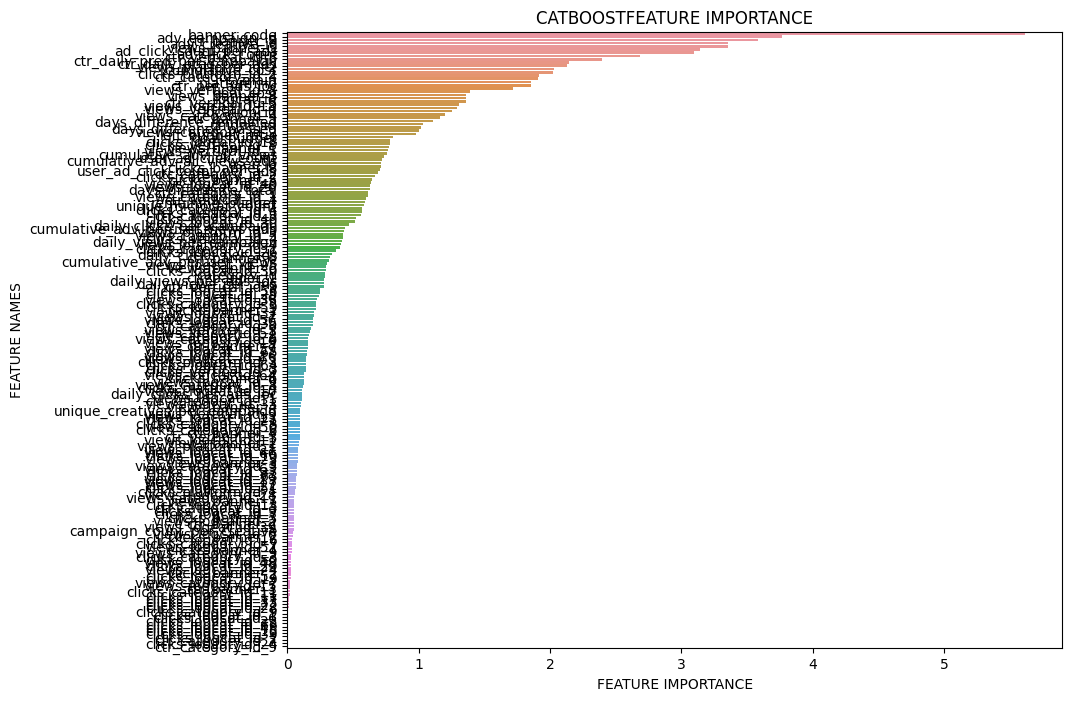

In [70]:


import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def plot_feature_importance(importance,names,model_type):
    
    #Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)
    
    #Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)
    
    #Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)
    
    #Define size of bar plot
    plt.figure(figsize=(10,8))
    #Plot Searborn bar chart
    sns.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    #Add chart labels
    plt.title(model_type + 'FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

#plot the catboost result
plot_feature_importance(fitted_models[1].get_feature_importance(),X.columns,'CATBOOST')

#cumulative_adv_all_views

In [72]:
test_data = test_data.to_pandas()



In [73]:
test_data.columns

Index(['unique_id', 'user_id', 'adv_campaign_id', 'platform_id',
       'adv_creative_id', 'event_date', 'banner_code', 'is_main', 'target',
       'start_date',
       ...
       'ctr_category_id_1', 'ctr_category_id_2', 'ctr_category_id_3',
       'ctr_category_id_4', 'ctr_category_id_5', 'ctr_category_id_6',
       'ctr_category_id_7', 'ctr_category_id_8', 'ctr_category_id_9',
       'ctr_category_id_11'],
      dtype='object', length=195)

In [74]:
from tqdm import tqdm


In [75]:
for i in tqdm(range(len(fitted_models))):
    
    
    
    
    
    test_data[f'predict_{i}'] = fitted_models[i].predict_proba(test_data[X.columns])[:,1]

100%|██████████| 6/6 [02:51<00:00, 28.64s/it]


In [76]:
test_data

,unique_id,user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target,start_date,...,ctr_category_id_7,ctr_category_id_8,ctr_category_id_9,ctr_category_id_11,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5
0,4045,95,2226,2,1764,2024-09-23,8,True,0,2024-09-17,...,0.0,0.0,0.0,0.0,0.042103,0.046412,0.044234,0.046120,0.043373,0.043645
1,4046,95,1387,2,3355,2024-09-23,8,True,0,2024-09-03,...,0.0,0.0,0.0,0.0,0.035049,0.034839,0.035837,0.036795,0.034552,0.033927
2,4047,95,883,2,1850,2024-09-23,8,True,0,2024-09-19,...,0.0,0.0,0.0,0.0,0.048443,0.046596,0.049025,0.050051,0.048961,0.050572
3,4049,95,3959,2,1388,2024-09-23,8,True,0,2024-09-17,...,0.0,0.0,0.0,0.0,0.053821,0.047505,0.052570,0.053113,0.055529,0.054862
4,4050,95,619,2,4063,2024-09-23,8,True,0,2024-09-05,...,0.0,0.0,0.0,0.0,0.067037,0.065371,0.067428,0.070578,0.071623,0.069117
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1983282,116724125,3263616,2783,2,276,2024-09-23,8,True,0,2024-09-20,...,0.0,0.0,0.0,0.0,0.049132,0.053189,0.051839,0.052241,0.049030,0.051376
1983283,116724126,3263616,1452,2,2377,2024-09-23,8,True,0,2024-09-20,...,0.0,0.0,0.0,0.0,0.040801,0.045143,0.041232,0.040538,0.039525,0.039300
1983284,116724127,3263616,1072,2,1667,2024-09-23,8,True,0,2024-09-17,...,0.0,0.0,0.0,0.0,0.057159,0.059084,0.054193,0.050070,0.053703,0.054520
1983285,116724128,3263616,228,2,2163,2024-09-23,8,True,0,2024-09-09,...,0.0,0.0,0.0,0.0,0.038498,0.041063,0.040206,0.040489,0.038636,0.038330


In [77]:
from scipy.stats import rankdata


In [78]:

def ensemble_predictions(predictions, weights, type_="linear"):
    assert np.isclose(np.sum(weights), 1.0)
    if type_ == "linear":
        res = np.average(predictions, weights=weights, axis=0)
    elif type_ == "harmonic":
        res = np.average([1 / p for p in predictions], weights=weights, axis=0)
        return 1 / res
    elif type_ == "geometric":
        numerator = np.average(
            [np.log(p) for p in predictions], weights=weights, axis=0
        )
        res = np.exp(numerator / sum(weights))
        return res
    elif type_ == "rank":
        res = np.average([rankdata(p) for p in predictions], weights=weights, axis=0)
        return res / (len(res) + 1)
    return res

In [80]:
test_data.head()
#test_data['predict'] = test_data[['predict_0','predict_1','predict_2']].mean(axis=1)

,unique_id,user_id,adv_campaign_id,platform_id,adv_creative_id,event_date,banner_code,is_main,target,start_date,...,ctr_category_id_7,ctr_category_id_8,ctr_category_id_9,ctr_category_id_11,predict_0,predict_1,predict_2,predict_3,predict_4,predict_5
0,4045,95,2226,2,1764,2024-09-23,8,True,0,2024-09-17,...,0.0,0.0,0.0,0.0,0.042103,0.046412,0.044234,0.046120,0.043373,0.043645
1,4046,95,1387,2,3355,2024-09-23,8,True,0,2024-09-03,...,0.0,0.0,0.0,0.0,0.035049,0.034839,0.035837,0.036795,0.034552,0.033927
2,4047,95,883,2,1850,2024-09-23,8,True,0,2024-09-19,...,0.0,0.0,0.0,0.0,0.048443,0.046596,0.049025,0.050051,0.048961,0.050572
3,4049,95,3959,2,1388,2024-09-23,8,True,0,2024-09-17,...,0.0,0.0,0.0,0.0,0.053821,0.047505,0.052570,0.053113,0.055529,0.054862
4,4050,95,619,2,4063,2024-09-23,8,True,0,2024-09-05,...,0.0,0.0,0.0,0.0,0.067037,0.065371,0.067428,0.070578,0.071623,0.069117


In [81]:
test_data['predict'] = test_data[['predict_0','predict_1','predict_2', 'predict_3', 'predict_4', 'predict_5']].mean(axis=1)

In [82]:
test_data[["user_id", "adv_campaign_id", "predict"]].to_csv("sample_submission_all_folds_v35.csv", index=False)